<a href="https://colab.research.google.com/github/mateusgomesc7/filtros-passivos/blob/master/Filtros_Passivos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aluno:** Mateus Gomes Correia

**Professor:** Lincon

**Disciplina:** Filtros

# Importações

In [2]:
# -*- coding: utf-8 -*-
from math import log10, pi, sin, cos, ceil
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from google.colab import widgets
from google.colab import output

# Classes

## Classe Butterworth

In [124]:
class butterworth:
    def __init__(self, tipo, Ap, As, Rl, **kwargs):
        self.tipo = tipo
        self.Ap = Ap
        self.As = As
        self.Rl = Rl
        self.Wp = kwargs.get('Wp', None)
        self.Ws = kwargs.get('Ws', None)
        self.Wp1 = kwargs.get('Wp1', None)
        self.Wp2 = kwargs.get('Wp2', None)
        self.Ws1 = kwargs.get('Ws1', None)
        self.Ws2 = kwargs.get('Ws2', None)

        if self.tipo == 'PF' or self.tipo == 'RF':
            self.Bp = self.Wp2 - self.Wp1
            self.Bs = self.Ws2 - self.Ws1

    
    def ordem(self):
        if self.tipo == "PB":
            self.n = log10( (pow(10,  (-self.As/10)) - 1) / (pow(10,(-self.Ap/10)) - 1) ) / (2*log10(self.Ws/self.Wp))
            self.N = ceil(self.n)
        elif self.tipo == "PA":
            self.n = log10( (pow(10, (-self.As/10)) - 1) / (pow(10,(-self.Ap/10)) - 1) ) / (2*log10(self.Wp/self.Ws))
            self.N = ceil(self.n)
        elif self.tipo == "PF":
            self.n = log10((10**(-self.Ap/10) - 1) / (10**(-self.As/10) - 1)) / (2*log10(self.Bp/self.Bs))
            self.N = ceil(self.n)
        elif self.tipo == "RF":
            self.n = log10((10**(-self.As/10) - 1) / (10**(-self.Ap/10) - 1)) / (2*log10(self.Bs/self.Bp))
            self.N = ceil(self.n)
        
    def freq_corte(self):
        if self.tipo == "PB":
            self.Wc = self.Wp / pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
        elif self.tipo == "PA":
            self.Wc = self.Wp * pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
        elif self.tipo == "PF":
            # calcula as freq de corte do PF(Wc1>>Wc2)
            #Wc PB
            self.Wc1 = self.Wp2 / pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
            # Wc PA
            self.Wc2 = self.Wp1 * pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
            self.W0 = np.sqrt(self.Wc1 * self.Wc2)
            self.Bw = self.Wc1 - self.Wc2
        elif self.tipo == "RF":
            # calcula as freq de corte do PF(Wc2>>Wc1)
            # Wc PB
            self.Wc1 = self.Wp1 / pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
            #Wc PA
            self.Wc2 = self.Wp2 *  pow((pow(10, (-self.Ap/10))-1), (1/(2*self.N)))
            self.W0 = np.sqrt(self.Wc1 * self.Wc2)
            self.Bw = self.Wc2 - self.Wc1
    
    # Essa função define e retorna as raízes do denominador da FT
    def polos_sistema(self):
        self.Sk = list()
        for k in range(1, self.N + 1):
            self.Sk.append(complex(-sin( (pi*(2*k-1)) / (2*self.N) ), cos( (pi*(2*k-1)) / (2*self.N) )))
    
    def funcao_transferencia(self):
        self.poli = list()
        self.poli = np.poly(self.Sk)
        self.coefReal = self.poli.real
        self.coef = list()
        if self.tipo == "PB":
            aux = 0
            for i in range(-self.N, 1):
                self.coef.append(self.coefReal[aux]*pow(self.Wc, i))
                aux = aux + 1
            self.H = signal.TransferFunction(self.coef[-1], self.coef)
        elif self.tipo == "PA":
            den = list()
            aux = self.N
            for i in range(0, self.N+1):
                self.coef.append(self.coefReal[aux]*pow(self.Wc, i))
                aux = aux - 1
                if i == 0:
                    den.append(self.coef[0])
                else:
                    den.append(0)
            self.H = signal.TransferFunction(den, self.coef)
        # FALTA AJEITAR
        if self.tipo == "PF" or self.tipo=="RF":
          aux = 0
          for i in range(-self.N, 1):
              self.coef.append(self.coefReal[aux]*pow(self.W0, i))
              aux = aux + 1
          self.H = signal.TransferFunction(coef[-1], coef)
    
    def plot_modulo(self):
        w, y, phase = signal.bode(self.H)
        plt.grid(True)
        plt.axis([0, 50000, -60, 10])
        if self.tipo == "PB":
            plt.annotate('Wc = ' + str(self.Wc), xy=(self.Wc, -3), xytext=(self.Wc + 5000, 5),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
        elif self.tipo == "PA":
            plt.annotate('Wc = ' + str(self.Wc), xy=(self.Wc, -3), xytext=(self.Wc + 5000, -10),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
        plt.plot(w, y)

    def plot_fase(self):
        w, y, phase = signal.bode(self.H)
        plt.grid(True)
        plt.plot(w, phase, 'r')
            
    
    # Essa função define e retorna os componenetes e seus valores do filtro
    def componentes_resultados(self, topologia = 'CLC'):
        self.elementos = 2*abs(np.real(self.Sk))
        comp = list()
        Ki = self.Rl
        self.R = Ki
        
        # Definição da topologia utilizada
        if topologia == "LCL":
            for i in range(0, self.N):
                if i%2 == 0:
                    comp.append("L")
                else:
                    comp.append("C")
        elif topologia == "CLC":
            for i in range(0, self.N):
                if i%2 == 0:
                    comp.append("C")
                else:
                    comp.append("L")
        self.comp = comp
        
        if self.tipo == "PB":
            # Transformação de Frequência
            self.elementos = self.elementos / self.Wc
            # Transformação de Impedância
            aux = 0
            for i in comp:
                if i == "C":
                    self.elementos[aux] = self.elementos[aux] / Ki
                elif i == "L":
                    self.elementos[aux] = self.elementos[aux] * Ki
                aux = aux + 1
        elif self.tipo == "PA":
            # Transformação de Frequência
            self.elementos = 1 / (self.elementos * self.Wc)
            # Transformação de Impedância
            aux = 0
            for i in comp:
                if i == "C":
                    self.elementos[aux] = self.elementos[aux] / Ki
                elif i == "L":
                    self.elementos[aux] = self.elementos[aux] * Ki
                aux = aux + 1
        elif self.tipo == "PF":
            # Transformações em freq e Z pra PF
            self.comp_pf=list()
            elementos_pf=list()
            aux=0
            for i in comp:
              ele_l=0
              ele_c=0
              if i == "C":
                  ele_l = (self.Bw/(self.elementos[aux]*self.W0**2)) * Ki
                  ele_c = (self.elementos[aux]/self.Bw) / Ki
                  elementos_pf.append([ele_l, ele_c])
                  self.comp_pf.append(["L","C","||"])
              elif i == "L":
                  ele_l=(self.elementos[aux]/self.Bw) * Ki
                  ele_c=(self.Bw/(self.elementos[aux]*self.W0**2)) / Ki
                  elementos_pf.append([ele_l, ele_c])
                  self.comp_pf.append(["L","C","- -"])
              aux = aux + 1
            self.elementos = elementos_pf
        elif self.tipo == "RF":
            # Transformações em freq e Z para RF
            self.comp_pf=list()
            elementos_pf=list()
            aux=0
            for i in comp:
              ele_l=0
              ele_c=0
              if i == "C":
 
                  ele_l = Ki/(self.Bw*(self.elementos[aux]))
                  ele_c = (self.elementos[aux]*self.Bw) / ((self.W0**2)*Ki)
                  elementos_pf.append([ele_l, ele_c])
                  self.comp_pf.append(["L","C","- -"])
              elif i == "L":
                  ele_l=(Ki*self.Bw*self.elementos[aux])/((self.W0**2))
                  ele_c=1/(self.elementos[aux]*self.Bw*Ki)
                  elementos_pf.append([ele_l, ele_c])
                  self.comp_pf.append(["L","C","||"])
              aux = aux + 1
            self.elementos = elementos_pf
        

    def mostrar_parametros(self):
        print('--------------------------------------------')
        print(f'n = {self.n:.5f}')
        print('--------------------------------------------')
        print(f'N = {self.N:.5f}')
        print('--------------------------------------------')
        if self.tipo == 'PB' or self.tipo == 'PA':
            print(f'Wc = {self.Wc:.5f}')
        elif self.tipo == 'PF' or self.tipo == 'RF':
            print(f'Wc1 = {self.Wc1:.5f}')
            print(f'Wc2 = {self.Wc2:.5f}')
            print(f'W0 = {self.W0:.5f}')
        print('--------------------------------------------')
        for index, Sk in enumerate(self.Sk, start=1):
            print(f'Sk({index}) =', Sk)
        print('--------------------------------------------')
        print(f'H = ', self.H)
        print('--------------------------------------------')
        if self.tipo == 'PB' or self.tipo == 'PA':
            for i in range(0, self.N):
                print(f'Componente {i+1}: {self.comp[i]}{i+1} - {self.elementos[i]:e}', sep=(""))
        elif self.tipo == 'PF' or self.tipo == 'RF':
            for i in range(0, self.N):
                print(f"Componente {i+1}: {self.comp[i]}{i+1}' => L{i+1}={self.elementos[i][0]:e} H e C{i+1}={self.elementos[i][1]:e} F => {self.comp_pf[i][2]}", sep=(""))
        print("Componente ", self.N+1, ": Rs - ", self.R, sep=(""))
        print("Componente ", self.N+2, ": Rl - ", self.R, sep=(""))
        print('--------------------------------------------')

    def run_butterworth(self):
        t = widgets.TabBar(["Parâmetros", "Fase", "Módulo"])
        with t.output_to(0):
          self.ordem()
          self.freq_corte()
          self.polos_sistema()
          self.funcao_transferencia()
          self.componentes_resultados()
          self.mostrar_parametros()
        with t.output_to(1):
          self.plot_fase()
        with t.output_to(2):
          self.plot_modulo()


## Classe Chebyshev

In [44]:
class chebyshev:
    def __init__(self, tipo, Ap, As, **kwargs):
        self.tipo = tipo
        self.Ap = Ap
        self.As = As
        self.Wp = kwargs.get('Wp', None)
        self.Ws = kwargs.get('Ws', None)
        self.Wp1 = kwargs.get('Wp1', None)
        self.Wp2 = kwargs.get('Wp2', None)
        self.Ws1 = kwargs.get('Ws1', None)
        self.Ws2 = kwargs.get('Ws2', None)
        self.Rl = kwargs.get('Rl', None)

    def constante_proporcionalidade(self):
        self.e = np.sqrt(pow(10, (-0.1*self.Ap)) - 1)
        print(f'e = {self.e:.5f}')

    def ordem(self):
        if self.tipo == 'PB':
            self.N = np.arccosh(np.sqrt(pow(10, (-0.1*self.As)) - 1) / self.e) / np.arccosh(self.Ws/self.Wp)
        elif self.tipo == 'PA':
            self.N = np.arccosh(np.sqrt(pow(10, (-0.1*self.As)) - 1) / self.e) / np.arccosh(self.Wp/self.Ws)
        elif self.tipo == 'PF':
            self.Bs = self.Ws2 - self.Ws1
            self.Bp = self.Wp2 - self.Wp1
            self.Bw = self.Bp
            self.W0 = np.sqrt(self.Wp1*self.Wp2)
            self.N = np.arccosh(np.sqrt(pow(10, (-0.1*self.As)) - 1) / self.e) / np.arccosh(self.Bs/self.Bp)

        print(f'n = {self.N:.5f}')
        self.N = int(np.ceil(self.N))
        print("N =", self.N)

    def freq_corte(self):
        self.Wc = self.Wp * np.cosh( (1/self.N) * np.arccosh(1/self.e) )
        print(f'Wc = {self.Wc:.5f}')

    def polos_do_sistema(self):
        self.Sk = list()
        self.Ok = list()
        self.Wk = list()
        for k in range(1, self.N+1):
            self.Ok.append(-np.sinh((1/self.N) * np.arcsinh(1/self.e) ) * np.sin(np.pi/(2*self.N)*(2*k - 1)))
            self.Wk.append(np.cosh((1/self.N) * np.arcsinh(1/self.e) ) * np.cos(np.pi/(2*self.N)*(2*k - 1)))
            self.Sk.append(complex(self.Ok[k-1], self.Wk[k-1]))
        print("Sk =", self.Sk)

    def polinomio_denominador(self):
        self.poli = np.poly(self.Sk)
        self.coef = self.poli.real

    def funcao_transferencia(self):
        D = list()
        if self.N % 2 != 0:
            aux = 0
            for i in range(-self.N, 1):
                D.append(self.coef[aux]*pow(self.Wp, i))
                aux = aux + 1
            self.H = signal.TransferFunction(D[-1], D)
            
        else:
            aux = np.sqrt(1 + self.e**2)
            self.H = signal.TransferFunction(D[-1], D)
        print("H =", self.H)

    def plot_modulo(self):
        w, y, phase = signal.bode(self.H)
        plt.ylabel('dB')
        plt.xlabel('Frequência')
        plt.grid(True)
        plt.xlim(0, 1000)
        plt.ylim(-5, 0)
        plt.axis([0, 50000, -60, 10])
        plt.annotate('Wc = ' + str(self.Wc), xy=(self.Wc, -3), xytext=(self.Wc + 5000, 5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
        plt.plot(w, y)
        plt.show()

    def plot_fase(self):
        w, y, phase = signal.bode(self.H)
        plt.grid(True)
        plt.xlim(0, 6000)
        plt.ylim(-300, 0)
        plt.plot(w, phase, 'r')
        plt.show()

    def run_chebyshev(self):
        t = widgets.TabBar(["Parâmetros", "Fase", "Módulo"])
        with t.output_to(0):
          self.constante_proporcionalidade()
          self.ordem()
          self.freq_corte()
          self.polos_do_sistema()
          self.polinomio_denominador()
          self.funcao_transferencia()
        with t.output_to(1):
          self.plot_fase()
        with t.output_to(2):
          self.plot_modulo()


# Rodando o código

## Filtro Butterworth

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------
n = 3.28110
--------------------------------------------
N = 4.00000
--------------------------------------------
Wc = 1184.00399
--------------------------------------------
Sk(1) =  (-0.3826834323650898+0.9238795325112867j)
Sk(2) =  (-0.9238795325112867+0.38268343236508984j)
Sk(3) =  (-0.9238795325112867-0.3826834323650897j)
Sk(4) =  (-0.3826834323650899-0.9238795325112867j)
--------------------------------------------
H =  TransferFunctionContinuous(
array([1.96522673e+12]),
array([1.00000000e+00, 3.09395152e+03, 4.78626802e+06, 4.33730373e+09,
       1.96522673e+12]),
dt: None
)
--------------------------------------------
Componente 1: C1 - 1.292845e-05
Componente 2: L2 - 7.803010e-02
Componente 3: C3 - 3.121204e-05
Componente 4: L4 - 3.232113e-02
Componente 5: Rs - 50
Componente 6: Rl - 50
--------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

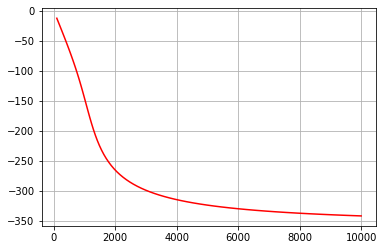

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

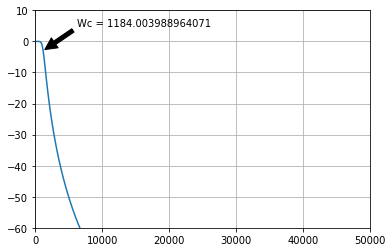

<IPython.core.display.Javascript object>

In [110]:
# Butterworth - Passa Baixas
filtro = butterworth(tipo='PB', Ap=-1, As=-40, Rl=50, Wp=1000, Ws=5000)
filtro.run_butterworth()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------
n = 3.28110
--------------------------------------------
N = 4.00000
--------------------------------------------
Wc = 4222.95875
--------------------------------------------
Sk(1) =  (-0.3826834323650898+0.9238795325112867j)
Sk(2) =  (-0.9238795325112867+0.38268343236508984j)
Sk(3) =  (-0.9238795325112867-0.3826834323650897j)
Sk(4) =  (-0.3826834323650899-0.9238795325112867j)
--------------------------------------------
H =  TransferFunctionContinuous(
array([1., 0., 0., 0., 0.]),
array([1.00000000e+00, 1.10351230e+04, 6.08869698e+07, 1.96793548e+11,
       3.18029462e+14]),
dt: None
)
--------------------------------------------
Componente 1: C1 - 3.093952e-06
Componente 2: L2 - 1.281557e-02
Componente 3: C3 - 1.281557e-06
Componente 4: L4 - 3.093952e-02
Componente 5: Rs - 100
Componente 6: Rl - 100
--------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

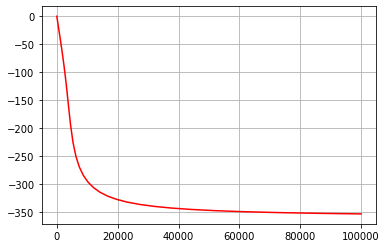

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

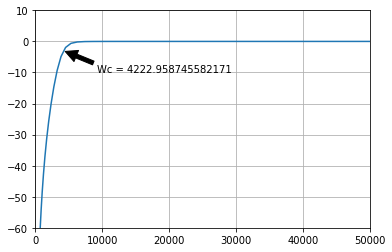

<IPython.core.display.Javascript object>

In [120]:
# Butterworth - Passa Altas
filtro = butterworth(tipo='PA', Ap=-1, As=-40, Rl=100, Wp=5000, Ws=1000)
filtro.run_butterworth()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------
n = 4.80673
--------------------------------------------
N = 5.00000
--------------------------------------------
Wc1 = 5723.37941
Wc2 = 1747.21948
W0 = 3162.27766
--------------------------------------------
Sk(1) =  (-0.3090169943749474+0.9510565162951535j)
Sk(2) =  (-0.8090169943749475+0.5877852522924731j)
Sk(3) =  (-1+6.123233995736766e-17j)
Sk(4) =  (-0.8090169943749475-0.587785252292473j)
Sk(5) =  (-0.3090169943749475-0.9510565162951535j)
--------------------------------------------
H =  TransferFunctionContinuous(
array([0.49130668]),
array([1.        , 0.98834121, 1.23840917, 0.49130668]),
dt: None
)
--------------------------------------------
Componente 1: C1' => L1=1.608390e-02 H e C1=6.217396e-06 F => ||
Componente 2: L2' => L2=1.017335e-02 H e C2=9.829608e-06 F => - -
Componente 3: C3' => L3=4.970200e-03 H e C3=2.011992e-05 F => ||
Componente 4: L4' => L4=1.017335e-02 H e C4=9.829608e-06 F => - -
Componente 5: C5' => L5=1.608390

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

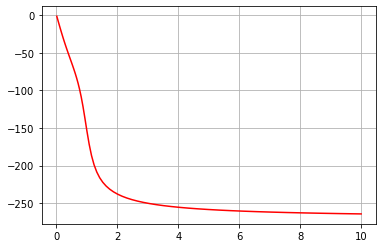

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

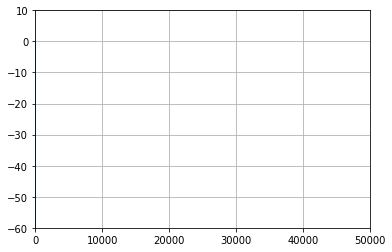

<IPython.core.display.Javascript object>

In [125]:
# Butterworth - Passa Faixa
filtro = butterworth(tipo='PF', Ap=-1, As=-40, Rl=25, Wp1=2000, Wp2=5000, Ws1=1000, Ws2=10000)
filtro.run_butterworth()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------
n = 6.90267
--------------------------------------------
N = 7.00000
--------------------------------------------
Wc1 = 2202.65303
Wc2 = 4539.97969
W0 = 3162.27766
--------------------------------------------
Sk(1) =  (-0.2225209339563144+0.9749279121818236j)
Sk(2) =  (-0.6234898018587335+0.7818314824680298j)
Sk(3) =  (-0.9009688679024191+0.4338837391175582j)
Sk(4) =  (-1+6.123233995736766e-17j)
Sk(5) =  (-0.9009688679024191-0.43388373911755806j)
Sk(6) =  (-0.6234898018587339-0.7818314824680295j)
Sk(7) =  (-0.2225209339563141-0.9749279121818237j)
--------------------------------------------
H =  TransferFunctionContinuous(
array([0.49130668]),
array([1.        , 0.98834121, 1.23840917, 0.49130668]),
dt: None
)
--------------------------------------------
Componente 1: C1' => L1=9.613460e+00 H e C1=1.040208e-08 F => - -
Componente 2: L2' => L2=2.914599e+00 H e C2=3.431004e-08 F => ||
Componente 3: C3' => L3=2.374329e+00 H e C3=4.211717e-08 F 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

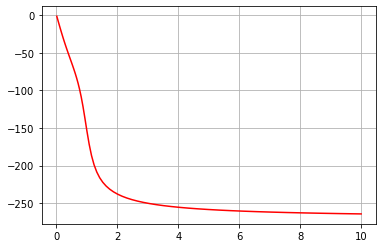

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

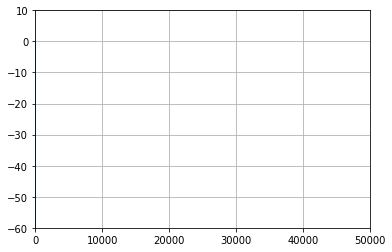

<IPython.core.display.Javascript object>

In [126]:
# Butterworth - Rejeita Faixa
filtro = butterworth(tipo='RF', Ap=-1, As=-60, Rl=10000, Wp1=2000, Wp2=5000, Ws1=1000, Ws2=10000)
filtro.run_butterworth()

## Filtro Chebyshev

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

e = 0.50885
n = 2.60591
N = 3
Wc = 1094.86802
Sk = [(-0.24708530247119018+0.965998674994867j), (-0.4941706049423804+6.830095168937499e-17j), (-0.24708530247119037-0.9659986749948668j)]
H = TransferFunctionContinuous(
array([4.91306682e+08]),
array([1.00000000e+00, 9.88341210e+02, 1.23840917e+06, 4.91306682e+08]),
dt: None
)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

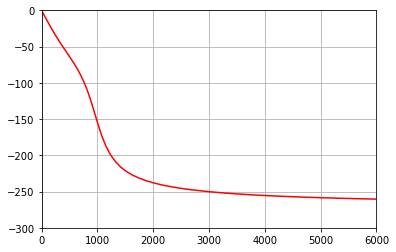

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

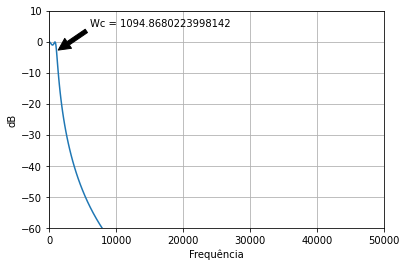

<IPython.core.display.Javascript object>

In [127]:
# Chebyshev - Passa Baixas
filtro = chebyshev(tipo='PB', Ap=-1, As=-40, Wp=1000, Ws=5000)
filtro.run_chebyshev()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

e = 0.50885
n = 2.60591
N = 3
Wc = 5474.34011
Sk = [(-0.24708530247119018+0.965998674994867j), (-0.4941706049423804+6.830095168937499e-17j), (-0.24708530247119037-0.9659986749948668j)]
H = TransferFunctionContinuous(
array([6.14133353e+10]),
array([1.00000000e+00, 4.94170605e+03, 3.09602293e+07, 6.14133353e+10]),
dt: None
)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

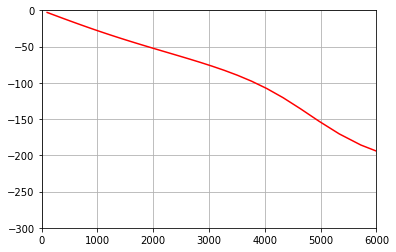

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

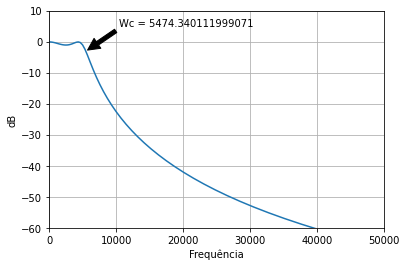

<IPython.core.display.Javascript object>

In [128]:
# Chebyshev - Passa Altas
filtro = chebyshev(tipo='PA', Ap=-1, As=-40, Wp=5000, Ws=1000)
filtro.run_chebyshev()

In [ ]:
# Chebyshev - Passa Faixa
filtro = chebyshev(tipo='PF', Ap=-1, As=-40, Wp1=2000, Wp2=5000, Ws1=1000, Ws2=10000, Rl=25)
filtro.run_chebyshev()

In [ ]:
# Chebyshev - Rejeita Faixa
filtro = butterworth(tipo='RF', Ap=-1, As=-60, Wp1=2000, Wp2=5000, Ws1=1000, Ws2=10000, Rl=10000)
filtro.run_chebyshev()